In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf

import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2

In [2]:
df_train = pd.read_csv('/mnt/sdb/DATASETS/diabetic_retinopathy/trainLabels.csv')
df_train.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [3]:
targets_series = pd.Series(df_train['level'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [4]:
im_size1 = 512
im_size2 = 512

x_train = []
y_train = []
x_test = []

In [5]:
i = 0 
for f, breed in tqdm(df_train.values):
    if i>501:
        break
    if type(cv2.imread('/mnt/sdb/DATASETS/diabetic_retinopathy/train/{}.jpeg'.format(f)))==type(None):
        continue
    else:
        img = cv2.imread('/mnt/sdb/DATASETS/diabetic_retinopathy/train/{}.jpeg'.format(f))
        label = one_hot_labels[i]
#         x_train.append(cv2.resize(img, (im_size1, im_size2)))
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)#cv2.COLOR_BGR2HSV)
#         cv2.imshow('show',img)
#         cv2.waitKey(0)
        x_train.append(cv2.resize(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (im_size1, im_size2)))
#         cv2.imshow('show',img)
#         cv2.waitKey(0)
        y_train.append(label)
        i += 1

np.save('x_train2',x_train)
np.save('y_train2',y_train)
print('Done')

  1%|▏         | 502/35126 [01:13<1:24:41,  6.81it/s]


Done


In [6]:
x_train = np.load('x_train2.npy')
y_train = np.load('y_train2.npy')

In [7]:
np.save('/mnt/sdb/DATASETS/diabetic_retinopathy/x_train2',x_train)
np.save('/mnt/sdb/DATASETS/diabetic_retinopathy/y_train2',y_train)

In [8]:
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.

In [9]:
print(x_train_raw.shape)
print(y_train_raw.shape)


(502, 512, 512)
(502, 5)


In [10]:
X_train, X_valid, train_labels, valid_labels = train_test_split(x_train_raw, y_train_raw, test_size=0.1, random_state=1)

In [11]:
train_labels.shape

(451, 5)

In [12]:
training_images = np.expand_dims(X_train, axis=3)
testing_images = np.expand_dims(X_valid, axis=3)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
)
    
# Keep These
print(training_images.shape)
print(testing_images.shape)

(451, 512, 512, 1)
(51, 512, 512, 1)


In [13]:
# Define the model
# Use no more than 2 Conv2D and 2 MaxPooling2D
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(512, 512, 1)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(26, activation='softmax')
# ])
############################3
num_class = y_train_raw.shape[1]
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights = None, include_top=False, input_shape=(512, 512, 1))
# base_model = ResNet50(weights = None, include_top=False, input_shape=(512, 512, 3))

# Add a new bottom layer
x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

###########################3333

In [14]:

# Compile Model. 
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Configure generators
train_gen = train_datagen.flow(
    training_images,
    train_labels,
    batch_size=5
)

val_gen = validation_datagen.flow(
    testing_images,
    valid_labels,
    batch_size=5
)



In [22]:
# Train the Model
history = model.fit(
    train_gen,
    epochs=2,
    validation_data=val_gen
)

model.evaluate(testing_images, valid_labels)

Epoch 1/2
91/91 [==============================] - 263s 3s/step - loss: 1.9181 - accuracy: 0.7317 - val_loss: 1.2762 - val_accuracy: 0.7451
Epoch 2/2
2/2 [==============================] - 6s 2s/step - loss: 1.1510 - accuracy: 0.7451


[1.1510448455810547, 0.7450980544090271]

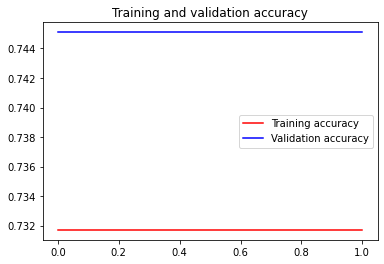

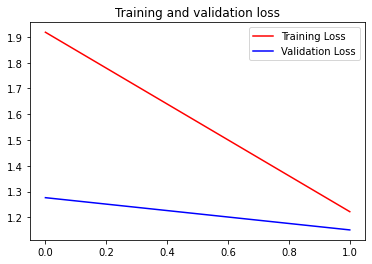

In [23]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
model.save('/mnt/sdb/DATASETS/diabetic_retinopathy/500img_model')

INFO:tensorflow:Assets written to: /mnt/sdb/DATASETS/diabetic_retinopathy/500img_model/assets


In [ ]:
#dont edit below

In [23]:
num_class = y_train_raw.shape[1]

In [24]:
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights = None, include_top=False, input_shape=(512, 512, 3))
# base_model = ResNet50(weights = None, include_top=False, input_shape=(512, 512, 1))

# Add a new bottom layer
x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
#for layer in base_model.layers:
#    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', verbose=1)]
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [25]:
model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])


In [2]:
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid), verbose=1)

NameError: name 'model' is not defined

In [27]:
model.save('/mnt/sdb/DATASETS/diabetic_retinopathy/500img_model')

INFO:tensorflow:Assets written to: /mnt/sdb/DATASETS/diabetic_retinopathy/500img_model/assets
